# Fantasy Premier League Project 

# BINARY

### Libraries 

In [1]:
import glob
import pandas as pd
import seaborn as sns
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# extract Features and target variables
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# Machine Learning Library
from sklearn.preprocessing import LabelEncoder # Encode Categorical Variable to Numerical Variable
from sklearn.impute import SimpleImputer # Imputer Class to replace missing values
from sklearn.metrics import confusion_matrix # Library for model evaluation
from sklearn.model_selection import train_test_split # Library to split datset into test and train

from sklearn.linear_model  import LogisticRegression # Logistic Regression Classifier
from sklearn.linear_model import SGDClassifier # Stochastic Gradient Descent Classifier
from sklearn.tree import DecisionTreeClassifier # Decision Tree Classifier
from sklearn.ensemble  import RandomForestClassifier # Random Forest Classifier
from sklearn.neighbors import KNeighborsClassifier # K Nearest neighbors Classifier
from sklearn.naive_bayes import GaussianNB #Naive Bayes Classifier
from sklearn.svm import SVC #Support vector Machine Classifier
from sklearn.ensemble import AdaBoostClassifier # Ada Boost Classifier
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score

### File reading

In [2]:
#list all csv files

fpl_files_23 = glob.glob('gw*_1.{}'.format('csv')) #fpl 2022-23 files
fpl_23= pd.concat([pd.read_csv(f) for f in fpl_files_23 ], ignore_index=True)

C:\Users\Joseph\AppData\Local\Temp\ipykernel_14476\1658855045.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fpl_23= pd.concat([pd.read_csv(f) for f in fpl_files_23 ], ignore_index=True)


## PREPROCESSING

In [3]:
fpl_23 = fpl_23[fpl_23['position']=='DEF']

In [4]:
#We transform all the strings which represent numeric values, to floats.
fpl_23[['value','total_points','assists','bonus','bps','clean_sheets','element','minutes','goals_conceded','goals_scored','own_goals','penalties_missed','penalties_saved','red_cards','saves','selected','starts','team_a_score','team_h_score','transfers_balance','transfers_in','transfers_out',"yellow_cards"]]=fpl_23[['value','total_points','assists','bonus','bps','clean_sheets','element','minutes','goals_conceded','goals_scored','own_goals','penalties_missed','penalties_saved','red_cards','saves','selected','starts','team_a_score','team_h_score','transfers_balance','transfers_in','transfers_out',"yellow_cards"]].astype(float)

In [5]:
# First, group by 'name' and 'round' and then take the mean of the matches for players with more than one match in a gameweek
fpl_23 = fpl_23.groupby(['name', 'round']).mean(numeric_only = True).reset_index()
# Now, you can set the index to the aggregated DataFrame
fpl_23.set_index(['name', 'round'], inplace=True)
# And sort the DataFrame by 'name' and 'round' again
fpl_23 = fpl_23.sort_values(by=['name', 'round'])

In [6]:
fpl_23.columns

Index(['xP', 'assists', 'bonus', 'bps', 'clean_sheets', 'creativity',
       'element', 'expected_assists', 'expected_goal_involvements',
       'expected_goals', 'expected_goals_conceded', 'goals_conceded',
       'goals_scored', 'ict_index', 'influence', 'minutes', 'own_goals',
       'penalties_missed', 'penalties_saved', 'red_cards', 'saves', 'selected',
       'starts', 'team_a_score', 'team_h_score', 'threat', 'total_points',
       'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'yellow_cards'],
      dtype='object')

In [7]:
def rolling_average(series, window):
    return series.rolling(min_periods=1, window=window).mean().shift(1)

def get_player_averages(df, stats):
    feature_names = []
    for stat in stats + ['total_points']:
        # Make sure the stat is a column in the dataframe
        if stat in df.columns:
            grouped = df.groupby('name')[stat]  # Group by name
            df['season_{}'.format(stat)] = grouped.transform(lambda x: rolling_average(x, 16))
            df['recent_{}'.format(stat)] = grouped.transform(lambda x: rolling_average(x, 4))
            df['prev_{}'.format(stat)] = grouped.transform(lambda x: rolling_average(x, 1))
            feature_names += [time + "_" + stat for time in ['season', 'recent', 'prev']]
        else:
            raise KeyError(f"The stat '{stat}' was not found in the dataframe.")
    return df, feature_names

# Example usage
stats = ['clean_sheets', 'expected_goals_conceded', 'goals_conceded', 'goals_scored', 'assists']

get_player_averages(fpl_23, stats)
fpl_23[['season_total_points', 'recent_total_points', 'prev_total_points', 'total_points']]

season_total_points  recent_total_points  \
name            round                                             
Aaron Cresswell 1                      NaN                  NaN   
                2                    1.000                 1.00   
                3                    1.500                 1.50   
                4                    1.000                 1.00   
                5                    2.250                 2.25   
...                                    ...                  ...   
Çaglar Söyüncü  34                   0.250                 1.00   
                35                   0.875                 3.50   
                36                   0.875                 3.50   
                37                   0.875                 3.00   
                38                   0.875                 2.50   

                       prev_total_points  total_points  
name            round                                   
Aaron Cresswell 1                    NaN           1.0  
                2                    1.0           2.0  
                3                    2.0           0.0  
                4                    0.0           6.0  
                5                    6.0           2.0  
...                                  ...           ...  
Çaglar Söyüncü  34                   2.0          10.0  
                35                  10.0           0.0  
                36                   0.0           0.0  
                37                   0.0           0.0  
                38                   0.0           0.0  

[8621 rows x 4 columns]

## Boxplots for checking outliers for our target value (total points)

We see from the boxplot that we have too many outliers.
This is likely happens because we take into account all the players in the premier league, even the ones that have little play time.
__These players have few to none points dragging down the mean, making the other regular players look like outliers.__

In [8]:
fpl_23.reset_index(inplace=True)

In [9]:
# We repeat the same process as before
player_means = fpl_23.groupby('name')['minutes'].mean()

# Filter for players with mean minutes fewer than 60
players_with_mean_zero = player_means[player_means <60]

# Remove players with mean minutes fewer than 60 from the original DataFrame
fpl_23 = fpl_23[~fpl_23['name'].isin(players_with_mean_zero.index)]

### We decided that we will not include any players with a mean value less than 60 minutes of playtime.
This way we focus on the players which are usually in the starting lineup, which are also more likely to score more points, making them a better choice for the Fantasy Team.

#### Interquaretile Range Method (IQR)

In [10]:
Q1 = fpl_23['total_points'].quantile(0.25)
Q3 = fpl_23['total_points'].quantile(0.75)
IQR = Q3-Q1
upper_whisker = min(Q3 + 1.5*IQR, max(fpl_23['total_points']))
lower_whisker = max(Q1 - 1.5*IQR, min(fpl_23['total_points']))
print("The Upper whisker is {} and the Lower whisker is {}.".format(upper_whisker,lower_whisker))

The Upper whisker is 11.0 and the Lower whisker is -3.0.


### Data Visualizations.

C:\Users\Joseph\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'total_points')

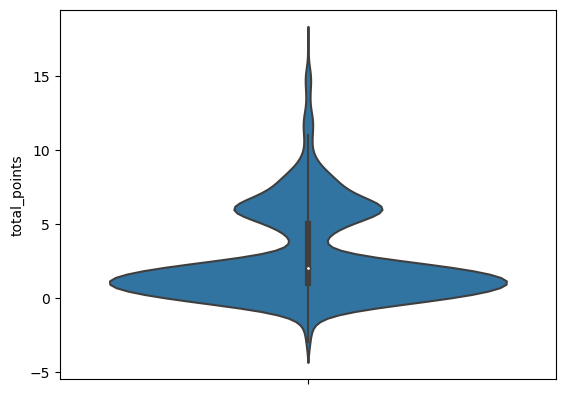

In [11]:
#Violin plot
fig, ax = plt.subplots()
sns.violinplot(data=fpl_23, y='total_points')
ax.set_ylabel('total_points')

### This is our 4 datasets: 
- Dataset with outliers
- Dataset without outliers
- Scaled Dataset with outliers
- Scaled Dataset without outliers

In [12]:
fpl_23.drop(columns = ['xP', 'assists', 'bonus', 'bps', 'clean_sheets',
       'creativity', 'element', 'expected_assists',
       'expected_goal_involvements', 'expected_goals',
       'expected_goals_conceded', 'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'minutes', 'own_goals', 'penalties_missed',
       'penalties_saved', 'red_cards', 'saves', 'selected', 'starts',
       'team_a_score', 'team_h_score', 'threat',
       'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'yellow_cards'], inplace=True, axis=1)

In [13]:
fpl_23.fillna(0,inplace=True)

In [14]:
fpl_23.isna().sum()

name                              0
round                             0
total_points                      0
season_clean_sheets               0
recent_clean_sheets               0
prev_clean_sheets                 0
season_expected_goals_conceded    0
recent_expected_goals_conceded    0
prev_expected_goals_conceded      0
season_goals_conceded             0
recent_goals_conceded             0
prev_goals_conceded               0
season_goals_scored               0
recent_goals_scored               0
prev_goals_scored                 0
season_assists                    0
recent_assists                    0
prev_assists                      0
season_total_points               0
recent_total_points               0
prev_total_points                 0
dtype: int64

In [15]:
#Dataset without outliers
fpl_23_no_outl = fpl_23[ (fpl_23['total_points'] >= lower_whisker) & (fpl_23['total_points'] <= upper_whisker) ]

# Scaled dataset with outliers
fpl_23_scaled = fpl_23.select_dtypes(include=['number'])
fpl_23_scaled = fpl_23_scaled.drop(['total_points'], axis=1)
rscaler = RobustScaler()

robustRescaledX = rscaler.fit_transform(fpl_23_scaled)
fpl_23_scaled = pd.DataFrame(robustRescaledX, columns=fpl_23_scaled.columns)
cols_to_add = ['total_points']

for col in cols_to_add:
    fpl_23_scaled[col] = fpl_23[col].reset_index(drop=True)


# Scaled dataset without outliers
fpl_23_scaled_no_outl = fpl_23_no_outl.select_dtypes(include=['number'])
fpl_23_scaled_no_outl = fpl_23_scaled_no_outl.drop(['total_points'], axis=1)
rscaler2 = RobustScaler()

robustRescaledX2 = rscaler2.fit_transform(fpl_23_scaled_no_outl)
fpl_23_scaled_no_outl = pd.DataFrame(robustRescaledX2, columns=fpl_23_scaled_no_outl.columns)
cols_to_add = ['total_points']

for col in cols_to_add:
    fpl_23_scaled_no_outl[col] = fpl_23_no_outl[col].reset_index(drop=True)

In [16]:
x=fpl_23.select_dtypes(include=['number'])
x=x.drop(columns=['total_points'])
y=fpl_23['total_points']

In [17]:
x_no_outl=fpl_23_no_outl.select_dtypes(include=['number'])
x_no_outl=x_no_outl.drop(columns=['total_points'])
y_no_outl=fpl_23_no_outl['total_points']

In [18]:
x_scaled=fpl_23_scaled.select_dtypes(include=['number'])
x_scaled=x_scaled.drop(columns=['total_points'])
# we use the y for our target value here

In [19]:
x_scaled_no_outl=fpl_23_scaled_no_outl.select_dtypes(include=['number'])
x_scaled_no_outl=x_scaled_no_outl.drop(columns=['total_points'])
# we use the y_no_outl for our target value here

#### Classification
Class 1: below or equal 4 points   
Class 2: 4 points and above  

#### new Y for classification for the dataset with outliers

In [20]:
ycl = pd.cut(y, bins = [-np.inf, 4, np.inf], labels =[0,1])
ycl.value_counts()

total_points
0    1139
1     456
Name: count, dtype: int64

In [21]:
# new Y for classification for the dataset without outliers
y_no_outl_cl = pd.cut(y_no_outl, bins = [-np.inf, 4, np.inf], labels =[0,1])
y_no_outl_cl.value_counts()

total_points
0    1139
1     430
Name: count, dtype: int64

#### Feature selection - Classifcation

best combination (ACC: 0.779): (0, 2, 3, 6, 9, 15)

all subsets:
 {1: {'feature_idx': (6,), 'cv_scores': array([0.68986985, 0.76272442, 0.65719945, 0.73555165, 0.70637896]), 'avg_score': 0.710344864864766, 'feature_names': ('prev_expected_goals_conceded',)}, 2: {'feature_idx': (6, 9), 'cv_scores': array([0.70330742, 0.76297188, 0.7107775 , 0.70667582, 0.73310818]), 'avg_score': 0.723368160010087, 'feature_names': ('prev_expected_goals_conceded', 'prev_goals_conceded')}, 3: {'feature_idx': (0, 6, 9), 'cv_scores': array([0.73900439, 0.80705616, 0.72066743, 0.71722288, 0.76573999]), 'avg_score': 0.7499381714804525, 'feature_names': ('round', 'prev_expected_goals_conceded', 'prev_goals_conceded')}, 4: {'feature_idx': (0, 2, 6, 9), 'cv_scores': array([0.77742923, 0.83686612, 0.73108397, 0.71625606, 0.79213549]), 'avg_score': 0.7707541708330459, 'feature_names': ('round', 'recent_clean_sheets', 'prev_expected_goals_conceded', 'prev_goals_conceded')}, 5: {'feature_idx': (0, 2, 3, 6, 9), 'cv_s

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: xlabel='Number of Features', ylabel='Performance'>)

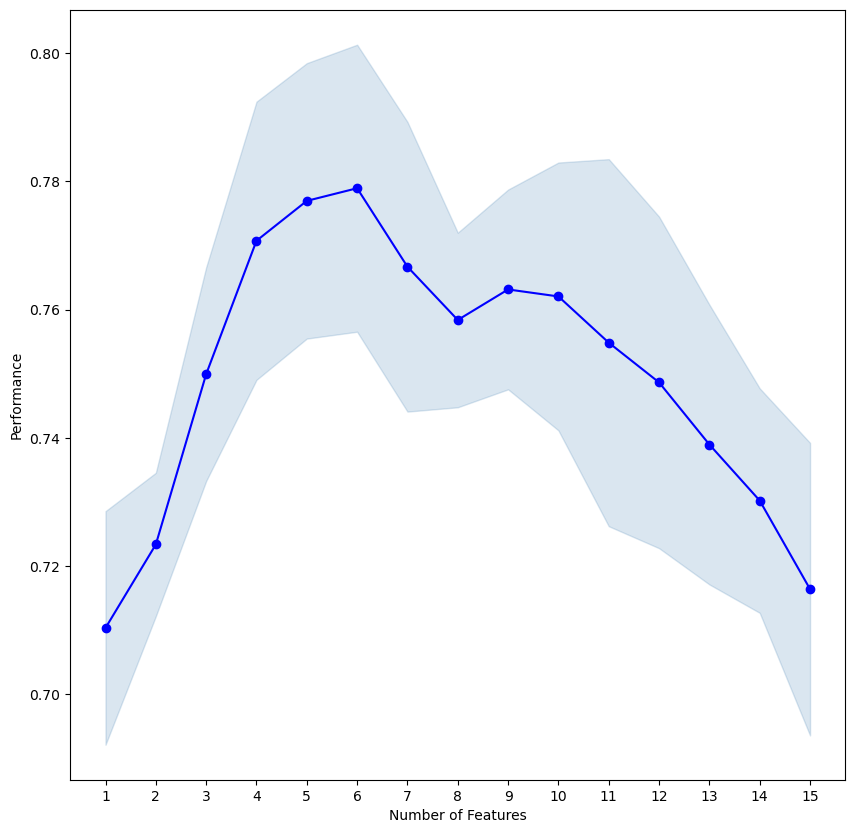

In [27]:
f1 = make_scorer(f1_score, average='weighted') #because we have imbalanced binary classification

rfc = RandomForestClassifier()
sfs_range = SFS(estimator=rfc, 
           k_features=(2, 15),
           forward=True, 
           floating=False, 
           scoring=f1,
           cv=5)

sfs_range = sfs_range.fit(x, ycl)

print('best combination (ACC: %.3f): %s\n' % (sfs_range.k_score_, sfs_range.k_feature_idx_))
print('all subsets:\n', sfs_range.subsets_)
plt.rcParams["figure.figsize"] = (10,10)
plot_sfs(sfs_range.get_metric_dict(), kind='std_err')

In [28]:
best_feature_names1 = x.columns[list(sfs_range.k_feature_idx_)]
best_feature_names1

Index(['round', 'recent_clean_sheets', 'prev_clean_sheets',
       'prev_expected_goals_conceded', 'prev_goals_conceded', 'prev_assists'],
      dtype='object')

best combination (ACC: 0.772): (0, 2, 3, 6, 9, 12)

all subsets:
 {1: {'feature_idx': (6,), 'cv_scores': array([0.69981538, 0.75956202, 0.66178342, 0.72883304, 0.70490282]), 'avg_score': 0.7109793354327599, 'feature_names': ('prev_expected_goals_conceded',)}, 2: {'feature_idx': (0, 6), 'cv_scores': array([0.7112518 , 0.77788729, 0.72035545, 0.71458155, 0.72353852]), 'avg_score': 0.7295229215483527, 'feature_names': ('round', 'prev_expected_goals_conceded')}, 3: {'feature_idx': (0, 6, 9), 'cv_scores': array([0.73890294, 0.81077818, 0.70387736, 0.72490316, 0.74328576]), 'avg_score': 0.7443494834671457, 'feature_names': ('round', 'prev_expected_goals_conceded', 'prev_goals_conceded')}, 4: {'feature_idx': (0, 2, 6, 9), 'cv_scores': array([0.75108514, 0.83262634, 0.71159875, 0.72035545, 0.78124481]), 'avg_score': 0.7593820956907473, 'feature_names': ('round', 'recent_clean_sheets', 'prev_expected_goals_conceded', 'prev_goals_conceded')}, 5: {'feature_idx': (0, 2, 3, 6, 9), 'cv_scores': arra

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: xlabel='Number of Features', ylabel='Performance'>)

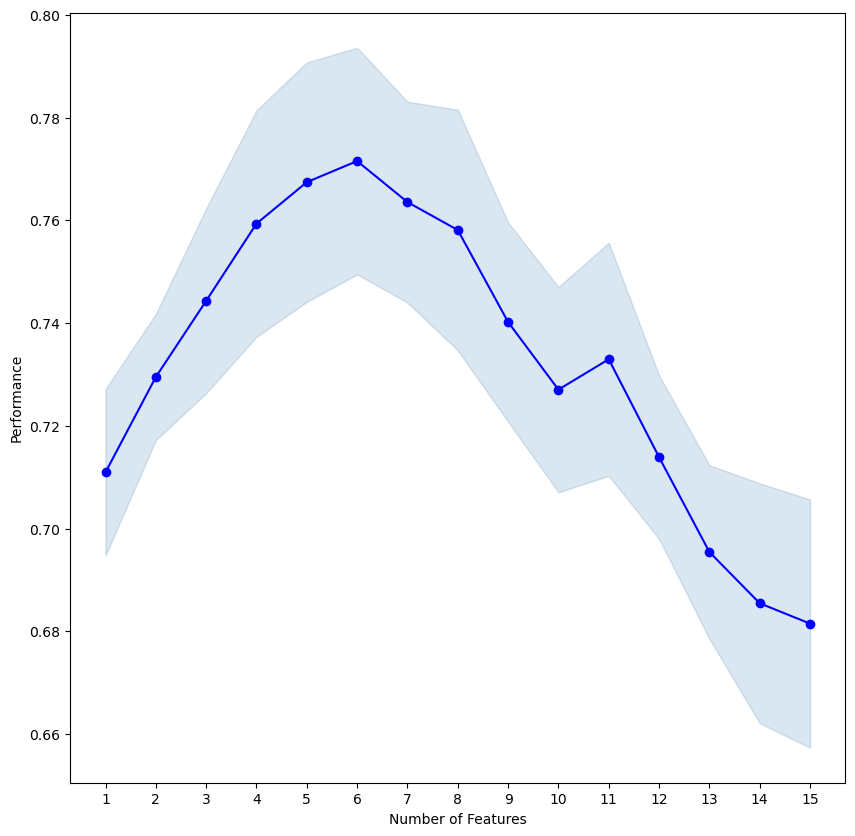

In [29]:
f1 = make_scorer(f1_score, average='weighted') #because we have imbalanced binary classification

dtc = DecisionTreeClassifier()
sfs_range = SFS(estimator=dtc, 
           k_features=(2, 15),
           forward=True, 
           floating=False, 
           scoring=f1,
           cv=5)

sfs_range = sfs_range.fit(x, ycl)

print('best combination (ACC: %.3f): %s\n' % (sfs_range.k_score_, sfs_range.k_feature_idx_))
print('all subsets:\n', sfs_range.subsets_)
plt.rcParams["figure.figsize"] = (10,10)
plot_sfs(sfs_range.get_metric_dict(), kind='std_err')

In [31]:
xnames2 = x.columns[list(sfs_range.k_feature_idx_)]
xnames2

Index(['round', 'recent_clean_sheets', 'prev_clean_sheets',
       'prev_expected_goals_conceded', 'prev_goals_conceded',
       'prev_goals_scored'],
      dtype='object')

In [23]:
X_sfs = x.loc[:,['round', 'recent_clean_sheets', 'prev_clean_sheets',
       'prev_expected_goals_conceded', 'prev_goals_conceded', 'prev_assists']]

In [24]:
#Dividing data into test & train splitting 80% data for training anf 20% for test
X_train, X_test, y_train, y_test = train_test_split(X_sfs, ycl, test_size=0.20)
print('There are {} samples in the training set and {} samples in the test set'.format(X_train.shape[0], X_test.shape[0]))

There are 1276 samples in the training set and 319 samples in the test set


In [25]:
plt.rcParams["figure.figsize"] = (5,5)

# Making a list of all classifiers
classifier_model = [LogisticRegression(max_iter=1000), KNeighborsClassifier(), GaussianNB(), SVC(), DecisionTreeClassifier(), RandomForestClassifier(), SGDClassifier(), AdaBoostClassifier()]

# Creating empty list to store the performance details
classifier_model_list= []
classifier_accuracy_test = []
classifier_accuracy_train = []
f1score = []
precisionscore = []
recallscore = []
avg_pre_rec_score = []
cv_score = []

for classifier_list in classifier_model:
    classifier = classifier_list
 
    # Fitting the training set into classification model
    classifier.fit(X_train,y_train)
    
    # Predicting the output on test dataset
    y_pred_test = classifier.predict(X_test)    
    score_test = accuracy_score(y_test, y_pred_test)
    
    # Predicting the output on training datset
    y_pred_train = classifier.predict(X_train) 
    score_train = accuracy_score(y_train, y_pred_train)
    
    # Cross Validation Score on training test
    scores = cross_val_score(classifier, X_train,y_train, cv=10)
    cv_score.append(scores.mean())
    
    #Keeping the model and accuracy score into a list
    classifier_model_list.append(classifier_list.__class__.__name__)
    classifier_accuracy_test.append(round(score_test,4))
    classifier_accuracy_train.append(round(score_train,4))
    
    #Precision, Recall and F1 score
    f1score.append(f1_score(y_test, y_pred_test, average ='weighted'))
    precisionscore.append(precision_score(y_test, y_pred_test, average ='weighted'))
    recallscore.append(recall_score(y_test, y_pred_test, average ='weighted'))
    
    #Calculating Average Precision Recall Score
    try:
        y_pred_score = classifier.decision_function(X_test)
    except:
        y_pred_score = classifier.predict_proba(X_test)[:,1]
    
    from sklearn.metrics import average_precision_score
    average_precision = average_precision_score(y_test, y_pred_score)
    avg_pre_rec_score.append(average_precision)
    


C:\Users\Joseph\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
#Creating pandas dataframe with Model and corresponding accuracy
#accuracy_df = pd.DataFrame({'Model':classifier_model_list , 'Test Accuracy':classifier_accuracy_test, 'Train Accuracy' :classifier_accuracy_test , 'Precision':precisionscore, 'Recall':recallscore ,'F1 Score':f1score},index=None)
accuracy_df = pd.DataFrame({'Model':classifier_model_list , 'Cross Val Score':cv_score, 'Test Accuracy' :classifier_accuracy_test , 'Precision':precisionscore, 'Recall':recallscore ,'Avg Precision Recall':avg_pre_rec_score ,'F1 Score':f1score})

# Calculating Average Accuracy = (Test + Train)/2
accuracy_df['Average_Accuracy'] =  (accuracy_df['Cross Val Score'] + accuracy_df['Test Accuracy'] )/ 2

#Arranging the Columns
print("\n*------------------------------    CLASSIFICATION MODEL PERFORMANCE EVALUATION      ---------------------*\n")
accuracy_df = accuracy_df[['Model','Cross Val Score', 'Test Accuracy', 'Average_Accuracy','Precision', 'Recall','Avg Precision Recall','F1 Score']]  # This will arrange the columns in the order we want

#Sorting the Columns based on Average Accuracy
accuracy_df.sort_values('Average_Accuracy', axis=0, ascending=False, inplace=True) # Sorting the data with highest accuracy in the top
accuracy_df
#accuracy_df.transpose()


*------------------------------    CLASSIFICATION MODEL PERFORMANCE EVALUATION      ---------------------*



,Model,Cross Val Score,Test Accuracy,Average_Accuracy,Precision,Recall,Avg Precision Recall,F1 Score
5,RandomForestClassifier,0.768830,0.7962,0.782515,0.790083,0.796238,0.632504,0.792084
4,DecisionTreeClassifier,0.764875,0.7743,0.769587,0.770127,0.774295,0.488314,0.771913
3,SVC,0.713958,0.7147,0.714329,0.510844,0.714734,0.304109,0.595829
7,AdaBoostClassifier,0.712383,0.7147,0.713542,0.659476,0.714734,0.428815,0.626397
0,LogisticRegression,0.713952,0.7116,0.712776,0.510203,0.711599,0.348464,0.594302
1,KNeighborsClassifier,0.719371,0.6959,0.707636,0.668357,0.695925,0.408879,0.676198
2,GaussianNB,0.698234,0.7053,0.701767,0.628997,0.705329,0.372482,0.620740
6,SGDClassifier,0.529774,0.6959,0.612837,0.581175,0.695925,0.297756,0.601764


In [26]:
# # Setting up the parameter grid for Random Forest and Decision Tree
# param_grid_rf = {
#     'n_estimators': [100, 200, 300, None],
#     'max_features': ['sqrt', 'log2'],
#     'max_depth': [4, 6, 8, None],
#     'criterion': ['gini', 'entropy']
# }


# param_grid_dt = {
#     'max_depth': [1, 2, 5, 10, None],
#     'min_samples_split': [2, 5, 10, None],
#     'criterion': ['gini', 'entropy', None]
# }

# # Creating the models
# model_rf = RandomForestClassifier()
# model_dt = DecisionTreeClassifier()

# # Setting up GridSearchCV
# grid_search_rf = GridSearchCV(estimator=model_rf, param_grid=param_grid_rf, cv=5, n_jobs=-1)
# grid_search_dt = GridSearchCV(estimator=model_dt, param_grid=param_grid_dt, cv=5, n_jobs=-1)

# # Fitting the models
# print("Performing Grid Search for Random Forest...")
# grid_search_rf.fit(X_train, y_train)

# print("Performing Grid Search for Decision Tree...")
# grid_search_dt.fit(X_train, y_train)

# # Getting the best parameters and scores
# print("Best parameters for Random Forest:", grid_search_rf.best_params_)
# print("Best score for Random Forest:", grid_search_rf.best_score_)

# print("Best parameters for Decision Tree:", grid_search_dt.best_params_)
# print("Best score for Decision Tree:", grid_search_dt.best_score_)

#### Grid Search CV with Random Forest Classifier

In [ ]:
# Random Forest classifier
clf_rf = RandomForestClassifier()

# Hyperparameters for the grid search
parameters_rf = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [4, 6, 8, 20, 30],
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf':[1, 2, 4, 6, 8, 10]
}

# Make a weighted F1 score scoring object using make_scorer()
scorer_rf = make_scorer(f1_score, average='weighted')

# Perform grid search on the classifier using 'scorer_rf' as the scoring method
# Default parameter of cv is 5
grid_obj_rf = GridSearchCV(estimator=clf_rf, param_grid=parameters_rf, scoring=scorer_rf, n_jobs=-1, cv = 5)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit_rf = grid_obj_rf.fit(X_train, y_train)

# Get the estimator
best_clf_rf = grid_fit_rf.best_estimator_

# Make predictions using the unoptimized and model
predictions_rf = (clf_rf.fit(X_train, y_train)).predict(X_test)
best_predictions_rf = best_clf_rf.predict(X_test)

# Report the before-and-after scores
print ("Unoptimized model\n------")
print ("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions_rf)))
print ("Weighted F1 score on testing data: {:.4f}".format(f1_score(y_test, predictions_rf, average='weighted')))
print ("\nOptimized Model\n------")
print ("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions_rf)))
print ("Final Weighted F1 score on the testing data: {:.4f}".format(f1_score(y_test, best_predictions_rf, average='weighted')))
print (best_clf_rf)


# n_jobs= -1???

In [ ]:
# Random Forest classifier
clf_rf = RandomForestClassifier()

# Hyperparameters for the grid search
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
#bootstrap = [True, False]

parameters_rf = {
    'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': max_depth,
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf':[1, 2, 4, 6, 8, 10, None],
    'bootstrap': [True, False]}
                  

# Make a weighted F1 score scoring object using make_scorer()
scorer_rf = make_scorer(f1_score, average='weighted')

# Perform grid search on the classifier using 'scorer_rf' as the scoring method
grid_obj_rf = GridSearchCV(estimator=clf_rf, param_grid=parameters_rf, scoring=scorer_rf, n_jobs=-1)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit_rf = grid_obj_rf.fit(X_train, y_train)

# Get the estimator
best_clf_rf = grid_fit_rf.best_estimator_

# Make predictions using the unoptimized and model
predictions_rf = (clf_rf.fit(X_train, y_train)).predict(X_test)
best_predictions_rf = best_clf_rf.predict(X_test)

# Report the before-and-after scores
print ("Unoptimized model\n------")
print ("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions_rf)))
print ("Weighted F1 score on testing data: {:.4f}".format(f1_score(y_test, predictions_rf, average='weighted')))
print ("\nOptimized Model\n------")
print ("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions_rf)))
print ("Final Weighted F1 score on the testing data: {:.4f}".format(f1_score(y_test, best_predictions_rf, average='weighted')))
print (best_clf_rf)


#### Grid Search CV Decision Tree Classifier

In [36]:
# Decision Tree classifier
clf_dt = DecisionTreeClassifier()

# Hyperparameters for the grid search
parameters_dt = {
    'max_depth': [1, 2, 5, 10],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Make a weighted F1 score scoring object using make_scorer()
scorer_dt = make_scorer(f1_score, average='weighted')

# Perform grid search on the classifier using 'scorer_dt' as the scoring method
grid_obj_dt = GridSearchCV(estimator=clf_dt, param_grid=parameters_dt, scoring=scorer_dt, n_jobs=-1)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit_dt = grid_obj_dt.fit(X_train, y_train)

# Get the estimator
best_clf_dt = grid_fit_dt.best_estimator_

# Make predictions using the unoptimized and model
predictions_dt = (clf_dt.fit(X_train, y_train)).predict(X_test)
best_predictions_dt = best_clf_dt.predict(X_test)

# Report the before-and-after scores
print ("Unoptimized model\n------")
print ("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions_dt)))
print ("Weighted F1 score on testing data: {:.4f}".format(f1_score(y_test, predictions_dt, average='weighted')))
print ("\nOptimized Model\n------")
print ("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions_dt)))
print ("Final Weighted F1 score on the testing data: {:.4f}".format(f1_score(y_test, best_predictions_dt, average='weighted')))
print (best_clf_dt)


Unoptimized model
------
Accuracy score on testing data: 0.7618
Weighted F1 score on testing data: 0.7452

Optimized Model
------
Final accuracy score on the testing data: 0.7241
Final Weighted F1 score on the testing data: 0.6922
DecisionTreeClassifier(max_depth=10)


# I will try the same algorithm with the whole dataset just to check if the sample we got for train set it's ok
(if we get similar scores)